In [48]:
from citalopram_project.load import load_spikes, load_neurons, load_events, get_data_dir
import pandas as pd
import numpy as np
from neurobox.compose import Pipeline
from spiketimes.df.binning import binned_spiketrain_bins_provided
from spiketimes.df.alignment import align_around_by
from spiketimes.df.statistics import mean_firing_rate_by
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore, zmap


def merge_connsecutive_sessions(df_current, df_next, df_neurons):
    df_neurons = df_neurons[["neuron_id", "cluster", "session_name", "group"]]
    df_current = df_current.merge(df_neurons)
    max_spikes = df_current.groupby(["neuron_id","session_name"], as_index=False).spiketimes.max().rename(columns={"spiketimes": "max_spike"})
    df_next = df_next.merge(max_spikes).assign(spiketimes=lambda x: x.spiketimes.add(x.max_spike)).loc[lambda x: x.spiketimes >= x.max_spike].drop("max_spike", axis=1).merge(df_neurons)
    return pd.concat([df_current, df_next])



neurons = load_neurons()
shock_spikes = load_spikes("base_shock").merge(neurons[["neuron_id", "cluster", "session_name", "group"]])
shock_events = load_events("base_shock")
post_shock_spikes = load_spikes("post_base_shock")
df_all = merge_connsecutive_sessions(shock_spikes, post_shock_spikes, neurons)

In [13]:
def align_spikes_to_events(df_data, df_events, t_before=None) -> pd.DataFrame:
    df = align_around_by(
    df_data=df_data,
    df_data_data_colname="spiketimes",
    df_data_group_colname="session_name", 
    df_events=df_events,
    df_events_event_colname="event_s", 
    df_events_group_colname="session_name", 
    t_before=t_before
    )
    return df

def rename(df, **column_mapping):
    return df.rename(columns=column_mapping)

def drop_cols(df, cols):
    return df.drop(cols, axis=1)

def dropna_rows(df):
    return df.dropna()

def bin_spikes(df, bin_width=0.01, t_before=-0.5, t_max=1.51, spikes_col="spiketimes"):
    bins = np.round(np.arange(t_before, t_max, bin_width), 3)
    return binned_spiketrain_bins_provided(df, 
                                bins=bins, 
                                spiketimes_col=spikes_col, 
                                spiketrain_col="neuron_id")

def exlude_using_spike_rate(df, min_rate, baseline_before=None):
    if baseline_before is not None:
        max_spike = baseline_before
    else:
        max_spike = df.spiketimes.max()
    idx = mean_firing_rate_by(df.loc[lambda x: x.spiketimes <= max_spike], spiketrain_col="neuron_id").loc[lambda x: x.mean_firing_rate > min_rate].neuron_id.values
    return df.loc[lambda x: x.neuron_id.isin(idx)]

def exclude_baseline(df, time_col, baseline_before=0, ):
    return df.loc[lambda x: x[time_col] >= baseline_before]

def pivot(df, time_col="time", neuron_col="neuron_id", value_col="values"):
    return pd.pivot(df, index=time_col, columns=neuron_col, values=value_col)

def standardize(df, baseline_before=None):
    def _standardize_col(col, baseline_before=None):
        if baseline_before is not None:
            return zmap(col, col.loc[lambda x: x.index < baseline_before])
        else:
            return zscore(col)
    return df.apply(_standardize_col, baseline_before=baseline_before)

def get_group_df(df, df_neurons, group):
    neurons = df_neurons.loc[lambda x: x.group == group].neuron_id.unique()
    return df[[c for c in df.columns if c in neurons]]

def counts_to_rate(df, bin_width, count_col="counts"):
    return df.assign(spike_rate = lambda x: x[count_col].divide(bin_width))

def gaussian_smooth(df, sigma):
    return df.apply(gaussian_filter1d, sigma=sigma)

def sort_by_activity_in_range(df, t_start, t_stop, agg_func):
    idx = df.loc[(df.index <= t_start) & (df.index <= t_stop)].apply(agg_func).sort_values(ascending=False).index.values
    return df[idx]



get_psth = Pipeline([
    (exclude_baseline, dict(time_col="spiketimes", baseline_before=0)),
    # (exlude_using_spike_rate, dict(min_rate=0.2)),
    (align_spikes_to_events, dict(df_events=shock_events, t_before=0.5)),
    (drop_cols, dict(cols=["spike_time_samples", "spiketimes"])),
    (rename, dict(aligned="spiketimes")),
    (bin_spikes, dict()),
    (pivot, dict(time_col="bin", value_col="counts")),
    # (standardize, dict(baseline_before=0)),
    (sort_by_activity_in_range, dict(t_start=0.1, t_stop=0.4, agg_func=np.mean)),
])

In [14]:
psths = get_psth.transform(shock_spikes.loc[lambda x: x.spiketimes >= 0])

In [19]:
psths

neuron_id,1533,1534,2111,1550,1459,2081,2183,1148,1379,2279,...,1391,1467,1397,1478,1254,1346,1335,1108,1129,1177
bin,,,,,,,,,,,,,,,,,,,,,
-0.50,132,57,58,54,63,42,54,37,44,34,...,0,0,0,0,0,0,0,0,0,0
-0.49,90,81,51,56,46,36,51,40,47,27,...,0,0,0,0,0,0,0,0,0,0
-0.48,148,71,61,68,53,31,60,45,43,30,...,0,0,0,0,0,0,0,0,0,0
-0.47,81,61,61,41,49,31,68,44,53,29,...,0,0,0,0,0,0,0,0,0,0
-0.46,131,64,48,72,54,29,54,41,57,37,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.45,125,74,52,52,54,44,59,39,37,41,...,0,0,0,0,0,0,0,0,0,0
1.46,107,67,48,61,59,32,45,43,43,33,...,0,0,0,0,0,0,0,0,0,0
1.47,116,72,66,62,53,33,56,48,48,41,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from scipy.stats import mannwhitneyu
from spiketimes.utils import p_adjust
from ezbootstrap import permutation_2sample

def permutation_prepost(col):
    x = col.loc[lambda x: (x.index < 0.02) | (x.index > 0.3)].values
    y = col.loc[lambda x: (x.index >= 0.02) & (x.index <= 0.3)].values
    obs = np.median(x) - np.median(y)
    reps = permutation_2sample(x, y, lambda x, y: np.median(x) - np.median(y), size=1000)
    p = np.mean(np.abs(reps) >= np.abs(obs)) * 2
    return pd.Series({"Observed Difference": obs, "p": p})

psth_res = (
    psths
    .apply(permutation_prepost)
    .transpose()
    .assign(p_adj = lambda x: p_adjust(x.p))
    .reset_index()
    .merge(load_neurons()[["session_name", "neuron_id", "group", "cluster"]])
    .assign(sig = lambda x: x.p_adj < 0.05)
)


In [22]:
psth_res

,neuron_id,Observed Difference,p,p_adj,session_name,group,cluster,sig
0,1533,-45.0,0.000,0.0,hamilton_19,sal,fast_firing,True
1,1534,-16.0,0.000,0.0,hamilton_19,sal,fast_firing,True
2,2111,-50.0,0.000,0.0,hamilton_28,discontinuation,slow_regular,True
3,1550,1.0,1.576,2.0,hamilton_19,sal,fast_firing,False
4,1459,-42.0,0.000,0.0,hamilton_08,continuation,slow_regular,True
...,...,...,...,...,...,...,...,...
604,1346,0.0,2.000,2.0,hamilton_23,continuation,None,False
605,1335,0.0,2.000,2.0,hamilton_23,continuation,None,False
606,1108,0.0,2.000,2.0,hamilton_02,continuation,None,False
607,1129,0.0,2.000,2.0,hamilton_12,discontinuation,slow_regular,False


<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

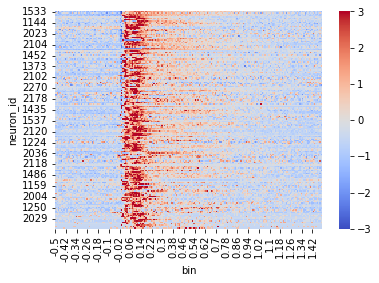

In [25]:
import seaborn as sns

def get_neuron_subset(df, neurons) -> pd.DataFrame:
    return df[[c for c in df.columns if c in neurons]]

neurons = psth_res.loc[lambda x: (x.sig) & (x["Observed Difference"] < 0)].neuron_id.values

dfp = get_neuron_subset(psths, neurons)
sns.heatmap(dfp.apply(zscore).transpose(), cmap="coolwarm", vmin =-3, vmax=3)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

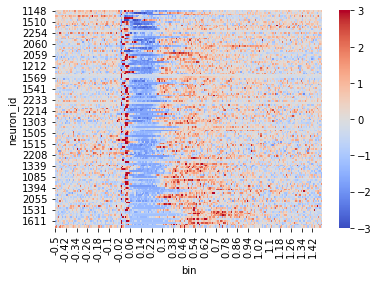

In [27]:
neurons = psth_res.loc[lambda x: (x.sig) & (x["Observed Difference"] > 0)].neuron_id.values

dfp = get_neuron_subset(psths, neurons)
sns.heatmap(dfp.apply(zscore).transpose(), cmap="coolwarm", vmin =-3, vmax=3)

In [28]:
# n neurons by group

psth_res.dropna().groupby("group").size()

group
continuation       157
discontinuation    213
sal                116
dtype: int64

In [29]:
# n neurons by cluster by group


psth_res.dropna().groupby(["cluster", "group"]).size()

cluster         group          
fast_firing     continuation         1
                discontinuation      9
                sal                 15
slow_irregular  continuation        80
                discontinuation    127
                sal                 51
slow_regular    continuation        76
                discontinuation     77
                sal                 50
dtype: int64

In [30]:
# compare pct correlated
from statsmodels.stats.proportion import proportions_ztest


def compare_pct(df):
    out = {}
    sal = df.loc[lambda x: x.group == "sal"]
    cit = df.loc[lambda x: x.group == "continuation"]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    out["prop_sal"] = sal.sig.mean()
    out["prop_cit"] = cit.sig.mean()
    z, p = proportions_ztest([sal.sig.sum(), cit.sig.sum()], [len(sal), len(cit)])
    out["statistic"] = z
    out["pval"] = p
    return pd.Series(out)


psth_res.dropna().groupby(["cluster"]).apply(compare_pct)

,n_sal,n_cit,prop_sal,prop_cit,statistic,pval
cluster,,,,,,
fast_firing,15.0,1.0,0.600000,1.000000,-0.800000,0.423711
slow_irregular,51.0,80.0,0.490196,0.437500,0.590254,0.555020
slow_regular,50.0,76.0,0.640000,0.473684,1.832492,0.066878


{'n_cit': 157,
 'n_sal': 116,
 'prop_cit': 0.6751592356687898,
 'prop_sal': 0.6724137931034483}


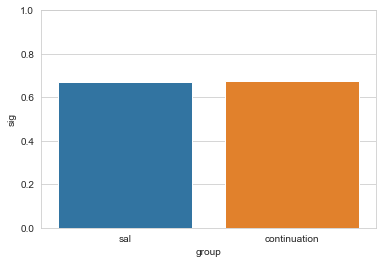

In [94]:
from pprint import pprint
import matplotlib.pyplot as plt 
sns.set_style("whitegrid")

out = {}
sal = psth_res.loc[lambda x: x.group == "sal"]
cit = psth_res.loc[lambda x: x.group == "continuation"]
out["n_sal"] = len(sal)
out["n_cit"] = len(cit)
out["prop_sal"] = sal.sig.mean()
out["prop_cit"] = cit.sig.mean()
z, p = proportions_ztest([sal.sig.sum(), cit.sig.sum()], [len(sal), len(cit)])


pprint(out)
psth_res.groupby("group")["sig"].mean().reset_index().pipe((sns.barplot, "data"), x="group", y="sig")
plt.ylim(0, 1)

plt.savefig("PSTH pct.svg")

In [50]:
# compare prop neg

def compare_neg(df):
    out = {}
    sal = df.loc[lambda x: (x.group == "sal") & (x.sig)]
    cit = df.loc[lambda x: (x.group == "continuation") & (x.sig)]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    out["prop_sal"] = (sal.statistic < 0).mean()
    out["prop_cit"] = (cit.statistic < 0).mean()
    z, p = proportions_ztest([(sal.statistic < 0).sum(), (cit.statistic < 0).sum()], [len(sal), len(cit)])
    out["statistic"] = z
    out["pval"] = p
    return pd.Series(out)


psth_res.dropna().groupby(["cluster"]).apply(compare_neg)

,n_sal,n_cit,prop_sal,prop_cit,statistic,pval
cluster,,,,,,
fast_firing,8.0,1.0,0.875000,0.000000,1.984313,0.047221
slow_irregular,35.0,52.0,0.914286,0.807692,1.367534,0.171458
slow_regular,30.0,52.0,0.500000,0.384615,1.017499,0.308916


n_sal         78.000000
n_cit        106.000000
prop_sal       0.692308
prop_cit       0.584906
statistic      1.491551
pval           0.135817
dtype: float64


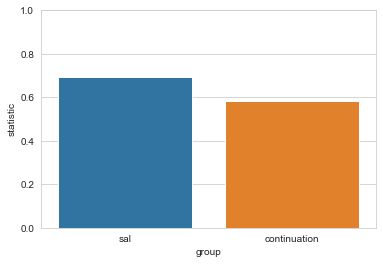

In [93]:
(
    psth_res
    .loc[lambda x: x.sig]
    .groupby("group", as_index=False)["statistic"]
    .apply(lambda x: (x < 0).mean() )
    .pipe((sns.barplot, "data"), x="group", y="statistic")
)


print(compare_neg(psth_res))
plt.ylim(0, 1)
plt.savefig("PSTH neg.svg")

In [32]:
# compare effect magnitude

def compare_mag(df):
    out = {}
    sal = df.loc[lambda x: (x.group == "sal")]
    cit = df.loc[lambda x: (x.group == "continuation")]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    x = sal["Observed Difference"].abs()
    y = cit["Observed Difference"].abs()
    u, p = mannwhitneyu(x, y)
    out["statistic"] = u
    out["pval"] = p
    return pd.Series(out)


psth_res.dropna().groupby(["cluster"]).apply(compare_mag)

,n_sal,n_cit,statistic,pval
cluster,,,,
fast_firing,15.0,1.0,6.0,0.413819
slow_irregular,51.0,80.0,1818.5,0.144987
slow_regular,50.0,76.0,1703.5,0.162449


n_sal         116.00000
n_cit         157.00000
statistic    9074.00000
pval            0.48052
dtype: float64


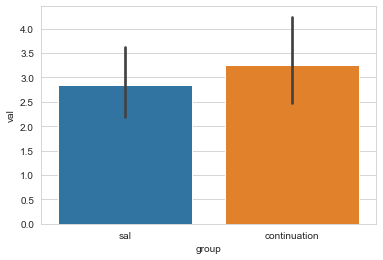

In [54]:
sns.barplot(data=psth_res.loc[lambda x: x.sig].assign(val=lambda x: x.statistic.abs()), x="group", y="val")


print(compare_mag(psth_res))

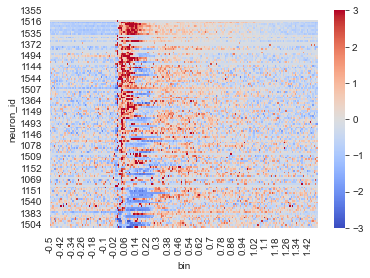

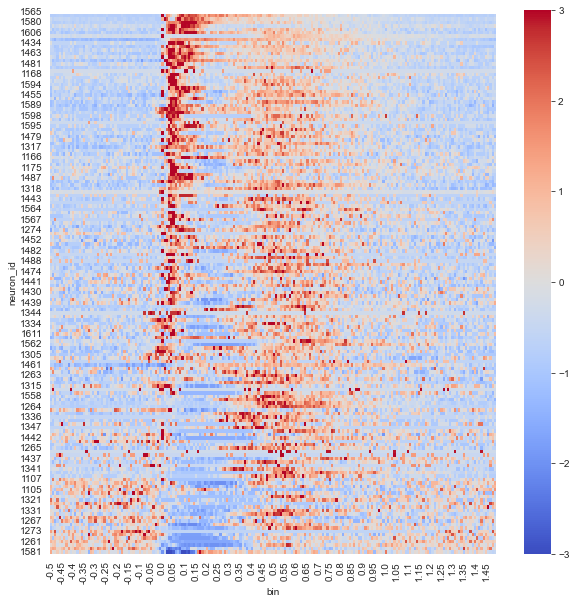

In [92]:
def get_neuron_subset(df, neurons) -> pd.DataFrame:
    return df[[c for c in df.columns if c in neurons]]

neurons = psth_res.loc[lambda x: x.group == "sal"].neuron_id.values

plt.figure(figsize=(10, 10))
dfp = get_neuron_subset(psths, neurons)
sns.heatmap(dfp.apply(zscore).transpose(), cmap="coolwarm", vmin =-3, vmax=3)
plt.savefig("Sal PSTH Heat.png", dpi=300)

plt.figure(figsize=(10, 10))
neurons = psth_res.loc[lambda x: x.group == "continuation"].neuron_id.values

dfp = get_neuron_subset(psths, neurons)
sns.heatmap(dfp.apply(zscore).transpose(), cmap="coolwarm", vmin =-3, vmax=3)
plt.savefig("Cit PSTH Heat.png", dpi=300)


# Ramp

In [33]:
get_ramp_responders = Pipeline([
    # (exlude_using_spike_rate, dict(min_rate=0.2, baseline_before=0)),
    (bin_spikes, dict(bin_width=30, t_before=-600, t_max=1200)),
    (counts_to_rate, dict(bin_width=1)),
    (pivot, dict(time_col="bin", value_col="spike_rate")),
    # (standardize, dict(baseline_before=0)),
    # (gaussian_smooth, dict(sigma=0.5)),
    (sort_by_activity_in_range, dict(t_start=1000, t_stop=1200, agg_func=np.mean)),
])

In [34]:
ramp = get_ramp_responders.transform(df_all)

In [35]:
def permutation_prepost(col):
    x = col.loc[lambda x: (x.index < 0) ].values
    y = col.loc[lambda x: (x.index >= 0)].values
    obs = np.median(x) - np.median(y)
    reps = permutation_2sample(x, y, lambda x, y: np.median(x) - np.median(y), size=1000)
    p = np.mean(np.abs(reps) >= np.abs(obs)) * 2
    return pd.Series({"statistic": obs, "p": p})

ramp_res = (
    ramp.dropna(axis=1)
    .loc[lambda x: x.index <= 600]
    .apply(permutation_prepost)
    .transpose()
    .assign(p_adj = lambda x: p_adjust(x.p))
    .reset_index()
    .merge(load_neurons()[["session_name", "neuron_id", "group", "cluster"]])
    .assign(sig = lambda x: x.p_adj < 0.05)
)
ramp_res

,neuron_id,statistic,p,p_adj,session_name,group,cluster,sig
0,1550,740.5,0.000,0.000000,hamilton_19,sal,fast_firing,True
1,1533,-1070.0,0.000,0.000000,hamilton_19,sal,fast_firing,True
2,1534,259.5,0.000,0.000000,hamilton_19,sal,fast_firing,True
3,1330,494.0,0.000,0.000000,hamilton_23,continuation,fast_firing,True
4,1146,78.5,0.008,0.012211,hamilton_13,sal,fast_firing,True
...,...,...,...,...,...,...,...,...
604,1081,0.0,2.000,2.000000,hamilton_01,sal,slow_regular,False
605,1404,0.0,2.000,2.000000,hamilton_07,sal,None,False
606,1335,0.0,2.000,2.000000,hamilton_23,continuation,None,False
607,1108,0.0,2.000,2.000000,hamilton_02,continuation,None,False


In [36]:
# compare pct correlated
from statsmodels.stats.proportion import proportions_ztest


def compare_pct(df):
    out = {}
    sal = df.loc[lambda x: x.group == "sal"]
    cit = df.loc[lambda x: x.group == "continuation"]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    out["prop_sal"] = sal.sig.mean()
    out["prop_cit"] = cit.sig.mean()
    z, p = proportions_ztest([sal.sig.sum(), cit.sig.sum()], [len(sal), len(cit)])
    out["statistic"] = z
    out["pval"] = p
    return pd.Series(out)


ramp_res.dropna().groupby(["cluster"]).apply(compare_pct)

,n_sal,n_cit,prop_sal,prop_cit,statistic,pval
cluster,,,,,,
fast_firing,15.0,1.0,0.733333,1.000000,-0.596285,0.550985
slow_irregular,51.0,80.0,0.843137,0.750000,1.267919,0.204827
slow_regular,50.0,76.0,0.840000,0.842105,-0.031638,0.974760


In [37]:
pprint(compare_pct(ramp_res))
plt.figure()
ramp_res.groupby("group")["sig"].mean().reset_index().pipe((sns.barplot, "data"), x="group", y="sig")
plt.ylim(0, 1)
plt.savefig("Ramp pct.svg")

NameError: name 'pprint' is not defined

In [38]:
# compare prop neg

def compare_neg(df):
    out = {}
    sal = df.loc[lambda x: (x.group == "sal") & (x.sig)]
    cit = df.loc[lambda x: (x.group == "continuation") & (x.sig)]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    out["prop_sal"] = (sal.statistic < 0).mean()
    out["prop_cit"] = (cit.statistic < 0).mean()
    z, p = proportions_ztest([(sal.statistic < 0).sum(), (cit.statistic < 0).sum()], [len(sal), len(cit)])
    out["statistic"] = z
    out["pval"] = p
    return pd.Series(out)


ramp_res.dropna().groupby(["cluster"]).apply(compare_neg)

,n_sal,n_cit,prop_sal,prop_cit,statistic,pval
cluster,,,,,,
fast_firing,11.0,1.0,0.181818,0.000000,0.467099,0.640429
slow_irregular,43.0,60.0,0.627907,0.666667,-0.406837,0.684128
slow_regular,42.0,64.0,0.595238,0.640625,-0.471516,0.637273


n_sal        114.000000
n_cit        163.000000
prop_sal       0.605263
prop_cit       0.693252
statistic     -1.518147
pval           0.128977
dtype: float64


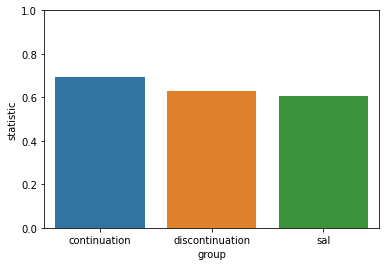

In [40]:
import matplotlib.pyplot as plt

plt.figure()
(
    ramp_res
    .loc[lambda x: x.sig]
    .groupby("group", as_index=False)["statistic"]
    .apply(lambda x: (x < 0).mean() )
    .pipe((sns.barplot, "data"), x="group", y="statistic")
)
plt.ylim(0, 1)
plt.savefig("Ramp Neg.svg")


print(compare_neg(ramp_res))


In [41]:
# compare effect magnitude

def compare_mag(df):
    out = {}
    sal = df.loc[lambda x: (x.group == "sal")]
    cit = df.loc[lambda x: (x.group == "continuation")]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    x = sal.statistic.abs()
    y = cit.statistic.abs()
    u, p = mannwhitneyu(x, y)
    out["statistic"] = u
    out["pval"] = p
    return pd.Series(out)


ramp_res.dropna().groupby(["cluster"]).apply(compare_mag)

,n_sal,n_cit,statistic,pval
cluster,,,,
fast_firing,15.0,1.0,2.0,0.138861
slow_irregular,51.0,80.0,1221.5,0.000056
slow_regular,50.0,76.0,1657.0,0.113266


In [42]:
pprint(compare_mag(ramp_res))

sns.barplot(data=ramp_res.loc[lambda x: x.sig].assign(val=lambda x: x.statistic.abs()), x="group", y="val")

NameError: name 'pprint' is not defined

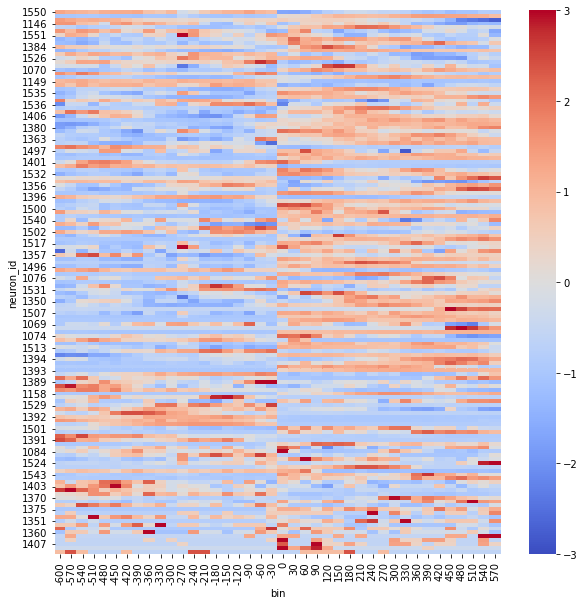

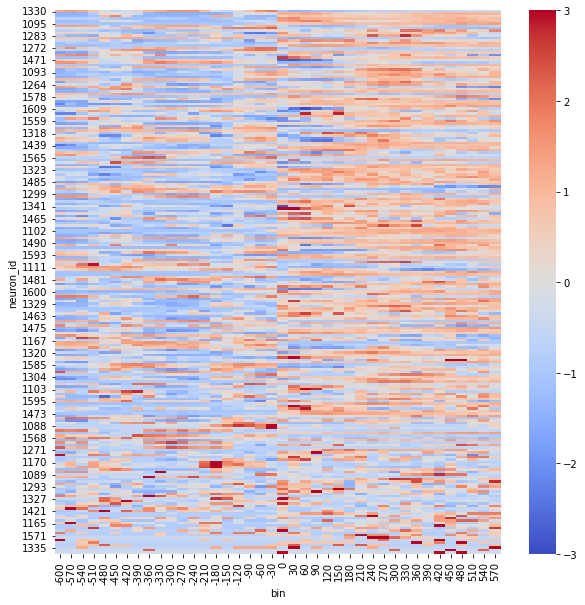

In [45]:
plt.figure(figsize=(10, 10))
neurons = ramp_res.loc[lambda x: x.group == "sal"].neuron_id.values
dfp = get_neuron_subset(ramp.apply(gaussian_filter1d, sigma=0.1).loc[lambda x: x.index < 600], neurons)
sns.heatmap(dfp.apply(zscore).transpose(), cmap="coolwarm", vmin =-3, vmax=3)
plt.savefig("Sal Ramp.png")

plt.figure(figsize=(10, 10))
neurons = ramp_res.loc[lambda x: x.group == "continuation"].neuron_id.values
dfp = get_neuron_subset(ramp.apply(gaussian_filter1d, sigma=0.1).loc[lambda x: x.index < 600], neurons)
sns.heatmap(dfp.apply(zscore).transpose(), cmap="coolwarm", vmin =-3, vmax=3)
plt.savefig("Cit Ramp.png")

In [49]:
derived_data_dir = get_data_dir() / "derived"

ramp_res.to_csv(derived_data_dir / "footshock_slow_timescale.csv", index=False)
psth_res.to_csv(derived_data_dir / "footshock_fast_timescale.csv", index=False)